# Figure 1d-e and Figure S2

This notebook loads the data and produces figures 1d, 1e, and S2. The intermediate files "figure1d.csv" and "figure1e_figureS2.csv" are saved here and reloaded to be used for the figure. You can reproduce the figure starting from that point in the code by downloading the two files from our data repository. 

In [1]:
savedate = '20251031'

In [2]:
# paths to load data
figure_folder = '' # path to figures folder
data_folder = '' # path to data - not needed for you to rerun figure
figure_data_folder = '' # save the data from the data repository here in a subfolder called "FigureData"

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as geopd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import us
state_list = [state.abbr for state in us.states.STATES]

# Read data

In [4]:
# Load blockgroup (BG) level data
df_bg_level = pd.read_csv(data_folder + '23_level_BG_US_imputedquantiles_20250722.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

In [5]:
# Sum stations by BG and Cty income quantile using US-level quantiles
county_col = 'income_quantile_county_US_imputed'
bg_col = 'income_quantile_bg_US_imputed'

n_square_us = df_bg_level.groupby([county_col, bg_col])['no_stations'].count()
df_square_us = pd.DataFrame(df_bg_level.groupby([county_col, bg_col])['no_stations'].sum())

# Arrange into square dataframe
df_square_plot_US = pd.DataFrame(np.zeros((5, 5)), 
                                 index=['bg_quantile_'+str(j) for j in [1,2,3,4,5]], 
                                 columns=['cty_quantile_'+str(j) for j in [1,2,3,4,5]])
df_square_plot_notnorm_US = pd.DataFrame(np.zeros((5, 5)), 
                                         index=['bg_quantile_'+str(j) for j in [1,2,3,4,5]],
                                         columns=['cty_quantile_'+str(j) for j in [1,2,3,4,5]])
for q_bg in [1,2,3,4,5]:
    for q_cty in [1,2,3,4,5]:
        df_square_plot_US.loc['bg_quantile_'+str(q_bg), 'cty_quantile_'+str(q_cty)] = df_square_us.loc[q_cty, q_bg]['no_stations'] / n_square_us.loc[q_cty, q_bg]
        df_square_plot_notnorm_US.loc['bg_quantile_'+str(q_bg), 'cty_quantile_'+str(q_cty)] = df_square_us.loc[q_cty, q_bg]['no_stations']

# Check
# df_square_plot_notnorm_US

In [6]:
# Sum stations by BG and Cty income quantile using state-level quantiles
county_col = 'income_quantile_county_state_imputed'
bg_col = 'income_quantile_bg_state_imputed'

n_square = df_bg_level.groupby([county_col, bg_col])['no_stations'].count()
df_square = pd.DataFrame(df_bg_level.groupby([county_col, bg_col])['no_stations'].sum())

# Arrange into square dataframe
df_square_plot_state = pd.DataFrame(np.zeros((5, 5)), 
                                    index=['bg_quantile_'+str(j) for j in [1,2,3,4,5]], 
                                    columns=['cty_quantile_'+str(j) for j in [1,2,3,4,5]])
df_square_plot_notnorm_state = pd.DataFrame(np.zeros((5, 5)), 
                                            index=['bg_quantile_'+str(j) for j in [1,2,3,4,5]], 
                                            columns=['cty_quantile_'+str(j) for j in [1,2,3,4,5]])
for q_bg in [1,2,3,4,5]:
    for q_cty in [1,2,3,4,5]:
        df_square_plot_state.loc['bg_quantile_'+str(q_bg), 'cty_quantile_'+str(q_cty)] = df_square.loc[q_cty, q_bg]['no_stations'] / n_square.loc[q_cty, q_bg]
        df_square_plot_notnorm_state.loc['bg_quantile_'+str(q_bg), 'cty_quantile_'+str(q_cty)] = df_square.loc[q_cty, q_bg]['no_stations']
        
# Check
# df_square_plot_notnorm_state

## Save and reload 
Then the following plotting script can be run by anyone using the posted data.

In [7]:
# Save
df_square_plot_notnorm_US.to_csv(figure_data_folder + 'FigureData/figure1d.csv')
df_square_plot_notnorm_state.to_csv(figure_data_folder + 'FigureData/figure1e_figureS2.csv')

### Run from here if reloading data

In [8]:
# Reload
df_square_plot_notnorm_US = pd.read_csv(figure_data_folder + 'FigureData/figure1d.csv', index_col=0)
df_square_plot_notnorm_state = pd.read_csv(figure_data_folder + 'FigureData/figure1e_figureS2.csv', index_col=0)

# Figure 1d uses US-level quantiles

### Square component

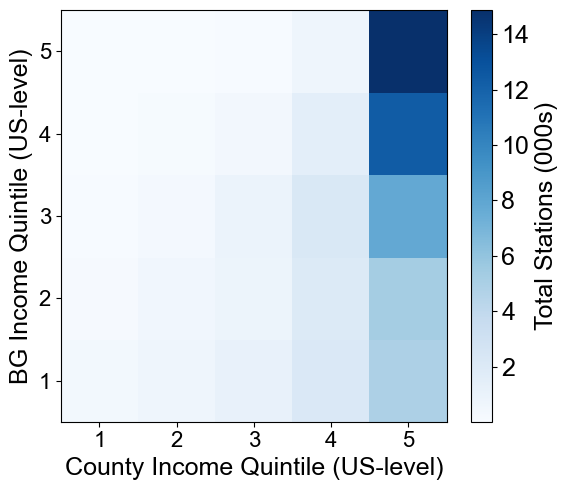

In [9]:
df_square_plot_notnorm_000s_US = df_square_plot_notnorm_US.copy()
df_square_plot_notnorm_000s_US = df_square_plot_notnorm_000s_US / 1000

plt.figure(figsize=(6,5))
plt.pcolor(np.arange(1, 6), np.arange(1, 6), df_square_plot_notnorm_000s_US, cmap='Blues')
plt.xlabel('County Income Quintile (US-level)', fontsize=18)
plt.ylabel('BG Income Quintile (US-level)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
cbar.set_label(label='Total Stations (000s)', fontsize=18)
plt.tight_layout()
plt.savefig('Figures/figure1d_pcolor_US_pcolor_'+savedate+'_blues.pdf', bbox_inches='tight')
plt.show()

### Side components

In [10]:
def bar_plot(t_here, unit='cty', savestr=None, xlabel=False, xlabeltext=None):
    
    plt.figure(figsize=(5,2))
        
    keys = [1, 2, 3, 4, 5]
    keys_back = [5, 4, 3, 2, 1]
    
    if unit == 'cty':
        plt.bar(keys, [(1/1000)*t_here['cty_quantile_'+str(key)] for key in keys], 0.8, color='grey')
        plt.yticks(fontsize=16)
    else:
        plt.bar(keys, [(1/1000)*t_here['bg_quantile_'+str(key)] for key in keys_back], 0.8, color='grey')
        if xlabel:
            plt.xticks(keys, labels=keys_back, fontsize=16)
        else:
            plt.xticks(keys, labels=keys_back)
        if xlabel:
            plt.xlabel(xlabeltext, fontsize=16)
        plt.yticks(fontsize=16)
    plt.ylabel('Total Stations [000s]', fontsize=16)
    plt.tight_layout()
    if savestr is not None:
        plt.savefig(savestr+'.pdf', bbox_inches='tight')
    plt.show()

In [11]:
def bar_plot_narrow(t_here, unit='cty', savestr=None, xlabel=False, xlabeltext=None):
    
    plt.figure(figsize=(5,3.5))
        
    keys = [1, 2, 3, 4, 5]
    keys_back = [5, 4, 3, 2, 1]
    
    if unit == 'cty':
        plt.bar(keys, [(1/1000)*t_here['cty_quantile_'+str(key)] for key in keys], 0.8, color='grey')
        plt.yticks(fontsize=16)
    else:
        plt.bar(keys, [(1/1000)*t_here['bg_quantile_'+str(key)] for key in keys], 0.8, color='grey')
        plt.xticks(keys, labels=keys, fontsize=16)
        if xlabel:
            plt.xlabel(xlabeltext, fontsize=16)
        plt.yticks(fontsize=16)
    plt.ylabel('Total Stations [000s]', fontsize=16)
    plt.tight_layout()
    if savestr is not None:
        plt.savefig(savestr+'.pdf', bbox_inches='tight')
    plt.show()

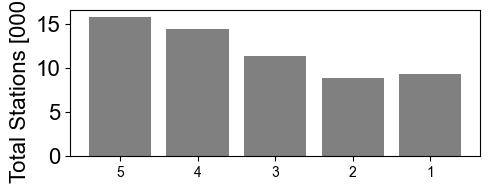

In [12]:
bar_plot(df_square_plot_notnorm_US.sum(axis=1), unit='bg', 
         savestr='Figures/figure1d_bar_bg_US_'+savedate)

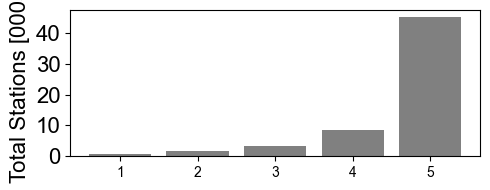

In [13]:
bar_plot(df_square_plot_notnorm_US.sum(axis=0), unit='cty', 
         savestr='Figures/figure1d_bar_county_US_'+savedate)

# Figure 1e and Figure S2 use the state-level quantiles

### Figure 1e

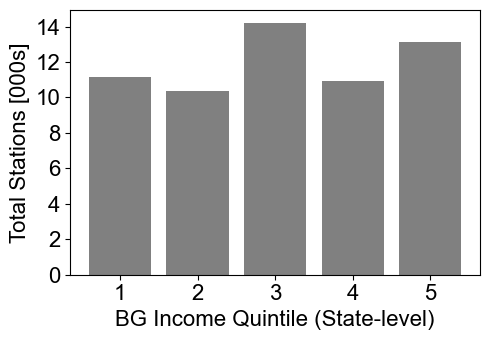

In [15]:
bar_plot_narrow(df_square_plot_notnorm_state.sum(axis=1), unit='bg', 
                savestr='Figures/figure1e_bar_bg_St_NARROW_'+savedate, 
                xlabel=True, xlabeltext='BG Income Quintile (State-level)')

### Figure S2

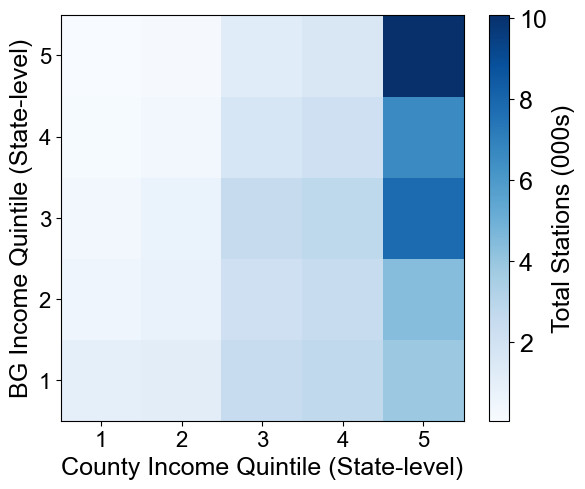

In [16]:
df_square_plot_notnorm_state_000s = df_square_plot_notnorm_state.copy()
df_square_plot_notnorm_state_000s = df_square_plot_notnorm_state_000s / 1000

plt.figure(figsize=(6,5))
plt.pcolor(np.arange(1, 6), np.arange(1, 6), df_square_plot_notnorm_state_000s, cmap='Blues')
plt.xlabel('County Income Quintile (State-level)', fontsize=18)
plt.ylabel('BG Income Quintile (State-level)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 
cbar.set_label(label='Total Stations (000s)', fontsize=18)
plt.tight_layout()
plt.savefig('Figures/figureS2_pcolor_St_'+savedate+'_blues.pdf', bbox_inches='tight')
plt.show()